# Dataset: CalTech 101

The dataset is the [CalTech 101 collection](https://data.caltech.edu/records/mzrjq-6wc02) of images from 101 categories. There are about 40 to 800 images in each category. 

# Imports and GPU Setup


In [2]:
### Acknowledgement
# The code and descriptions are originally written by Will Koehrsen
###################################################################

from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

# Setup Smaller Dataset from Caltech-101

In [3]:
import numpy as np
import math
from typing import List
import os
import argparse
import glob
import shutil

def list_files(path):
    files = os.listdir(path)
    return np.asarray(files)

def split_files(oldpath, newpath, classes):
    for name in classes:
        full_dir = f"{oldpath}/{name}"
        

        files = list_files(full_dir)
        
        total_file = np.size(files,0)
        # We split data set into 3: train, validation and test

        train_size = math.ceil(total_file * 3/4) # 75% for training 

        validation_size = train_size + math.ceil(total_file * 1/8) # 12.5% for validation
        test_size = validation_size + math.ceil(total_file * 1/8) # 12.5x% for testing 

        train = files[0:train_size]
        validation = files[train_size:validation_size]
        test = files[validation_size:]

        move_files(train, full_dir, f"train/{name}")
        move_files(validation, full_dir, f"validation/{name}")
        move_files(test, full_dir, f"test/{name}")

def move_files(files, old_dir, new_dir):
    new_dir = new_dir
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    print(new_dir)
    

    for file in np.nditer(files):
        old_file_path = f"{old_dir}/{file}"
        new_file_path = f"{new_dir}/{file}"

        shutil.move(old_file_path, new_file_path)

# classes = ['Leopards', 'airplanes', 'butterfly', 'camera', 'elephant', 'lamp', 'watch', 'umbrella', 'rhino'];
# split_files('/home/anagh/Downloads/caltech-101/101_ObjectCategories', '/home/anagh/Downloads/caltech-101/', classes)

In [4]:
# Location of data

train_dir = "./caltech-101/train"
valid_dir = "./caltech-101/validation"
test_dir = "./caltech-101/test"

save_file_name = 'vgg16-finetuned.pt'
checkpoint_path = 'vgg16-finetuned.pth'

# Change to fit hardware
batch_size = 128

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
2 gpus detected.


# Image Preprocessing

To prepare the images for our network, we have to resize them to 224 x 224 and normalize each color channel by subtracting a mean value and dividing by a standard deviation. We will also augment our training data in this stage. These operations are done using image `transforms`, which prepare our data for a neural network.

### Data Augmentation

Because there are a limited number of images in some categories, we can use image augmentation to artificially increase the number of images "seen" by the network. This means for training, we randomly resize and crop the images and also flip them horizontally. A different random transformation is applied each epoch (while training), so the network effectively sees many different versions of the same image. All of the data is also converted to Torch `Tensor`s before normalization. The validation and testing data is not augmented but is only resized and normalized. The normalization values are standardized for Imagenet. 

In [16]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Examples of Augmentation

To show how augmentation works, we need to write a function that will plot a tensor as an image.

In [17]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

We'll work with two example images and apply the train transformations.

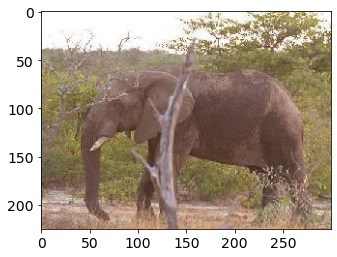

In [18]:
ex_img = Image.open('./caltech-101/train/elephant/image_0001.jpg')
plt.imshow(ex_img)

<Figure size 1728x1728 with 0 Axes>

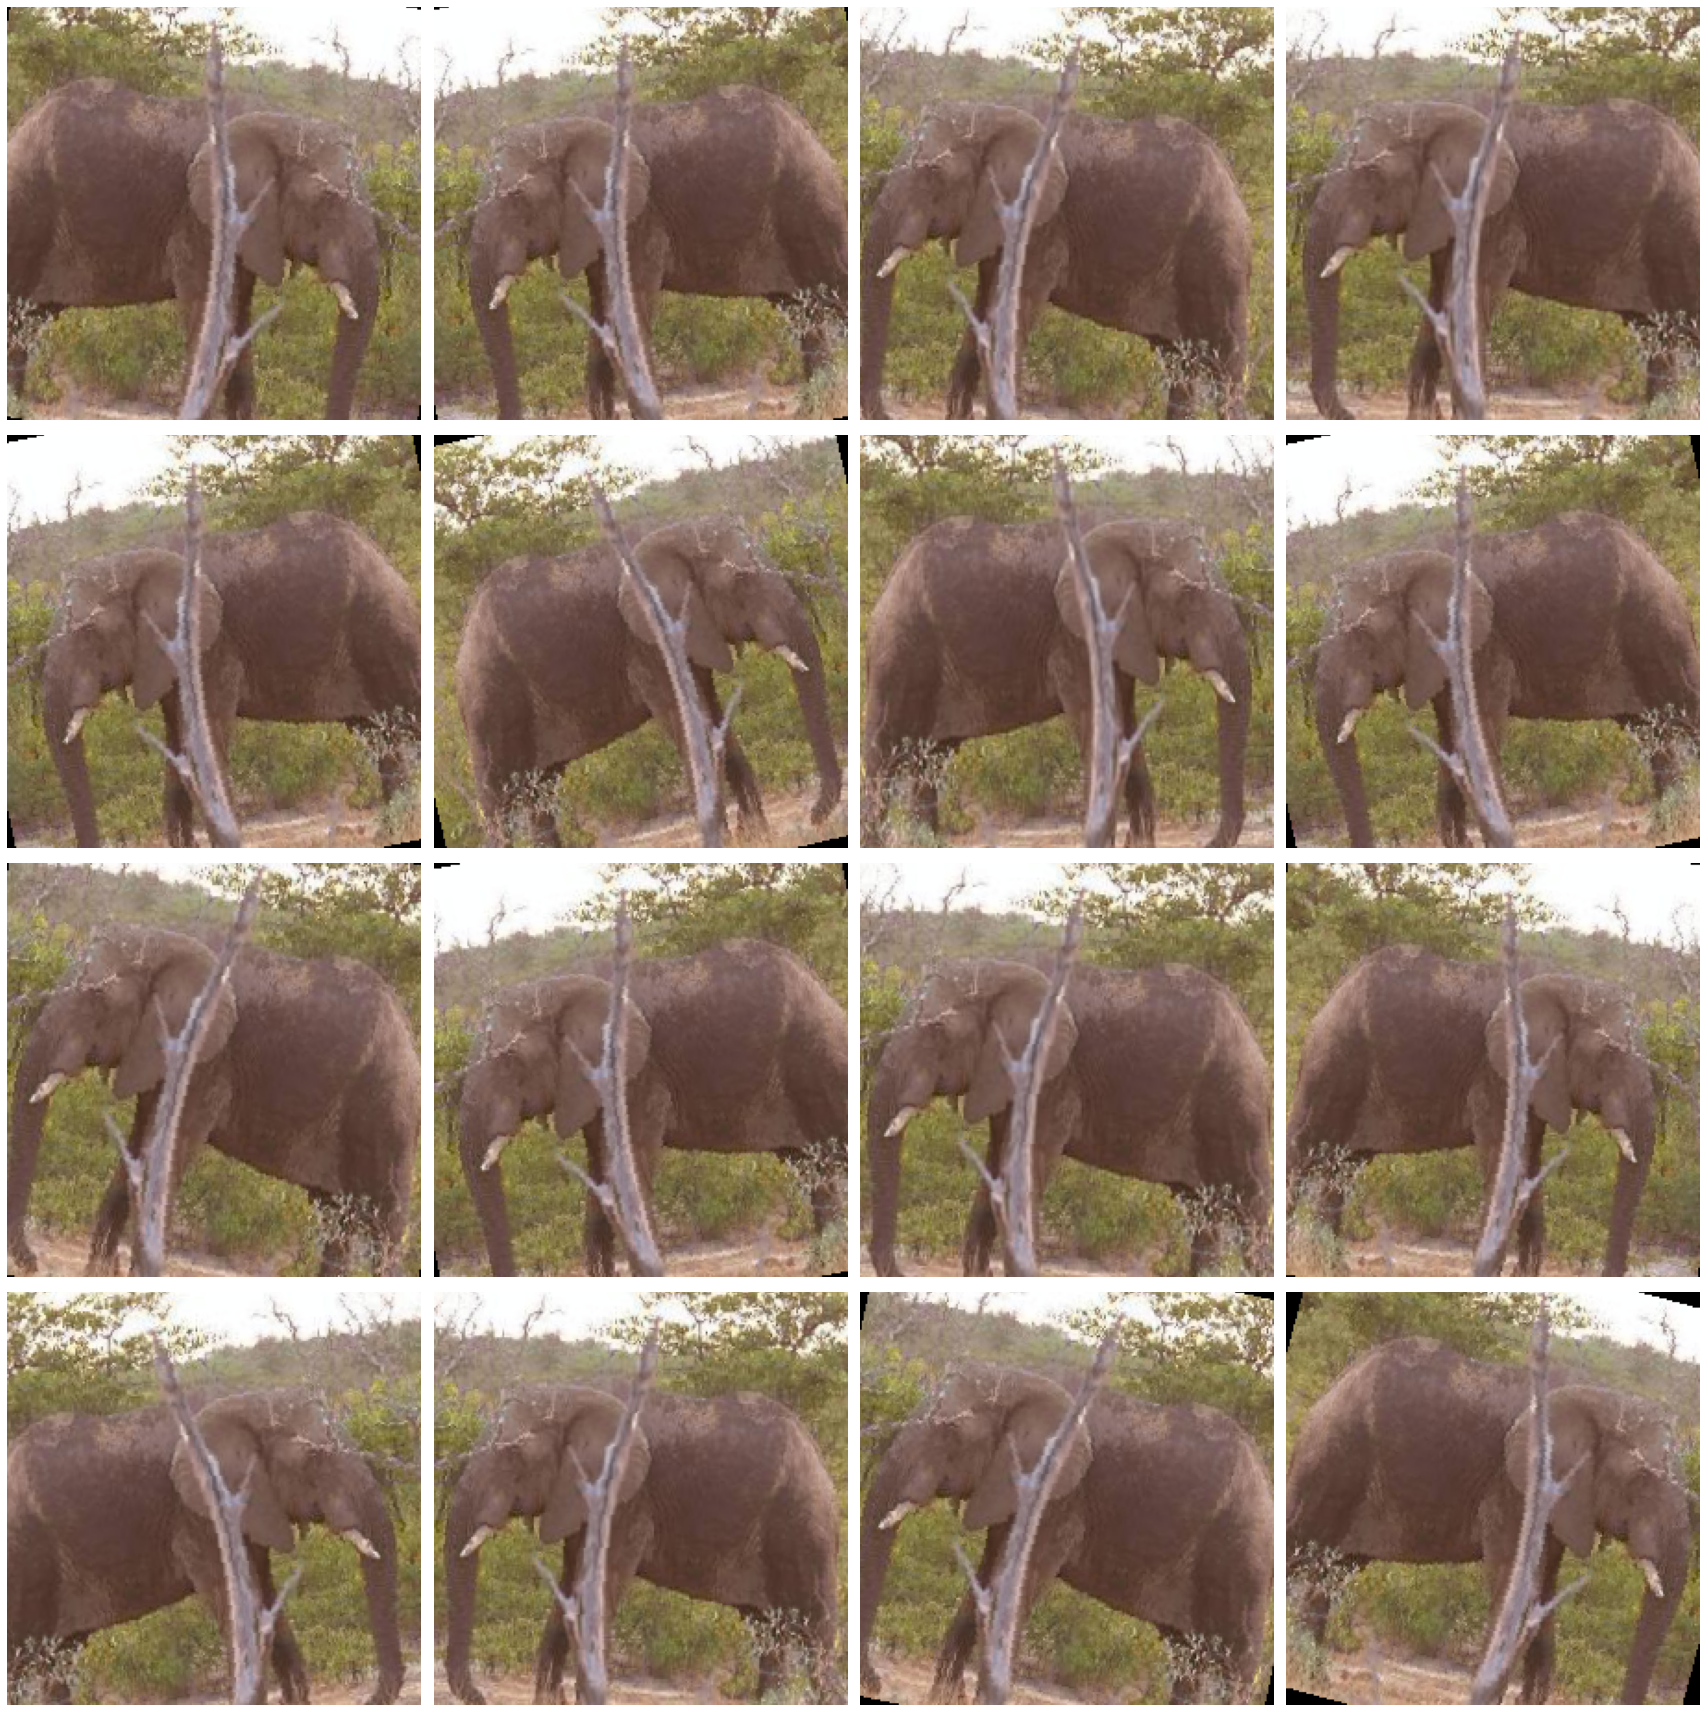

In [19]:
t = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

<Figure size 1728x1728 with 0 Axes>

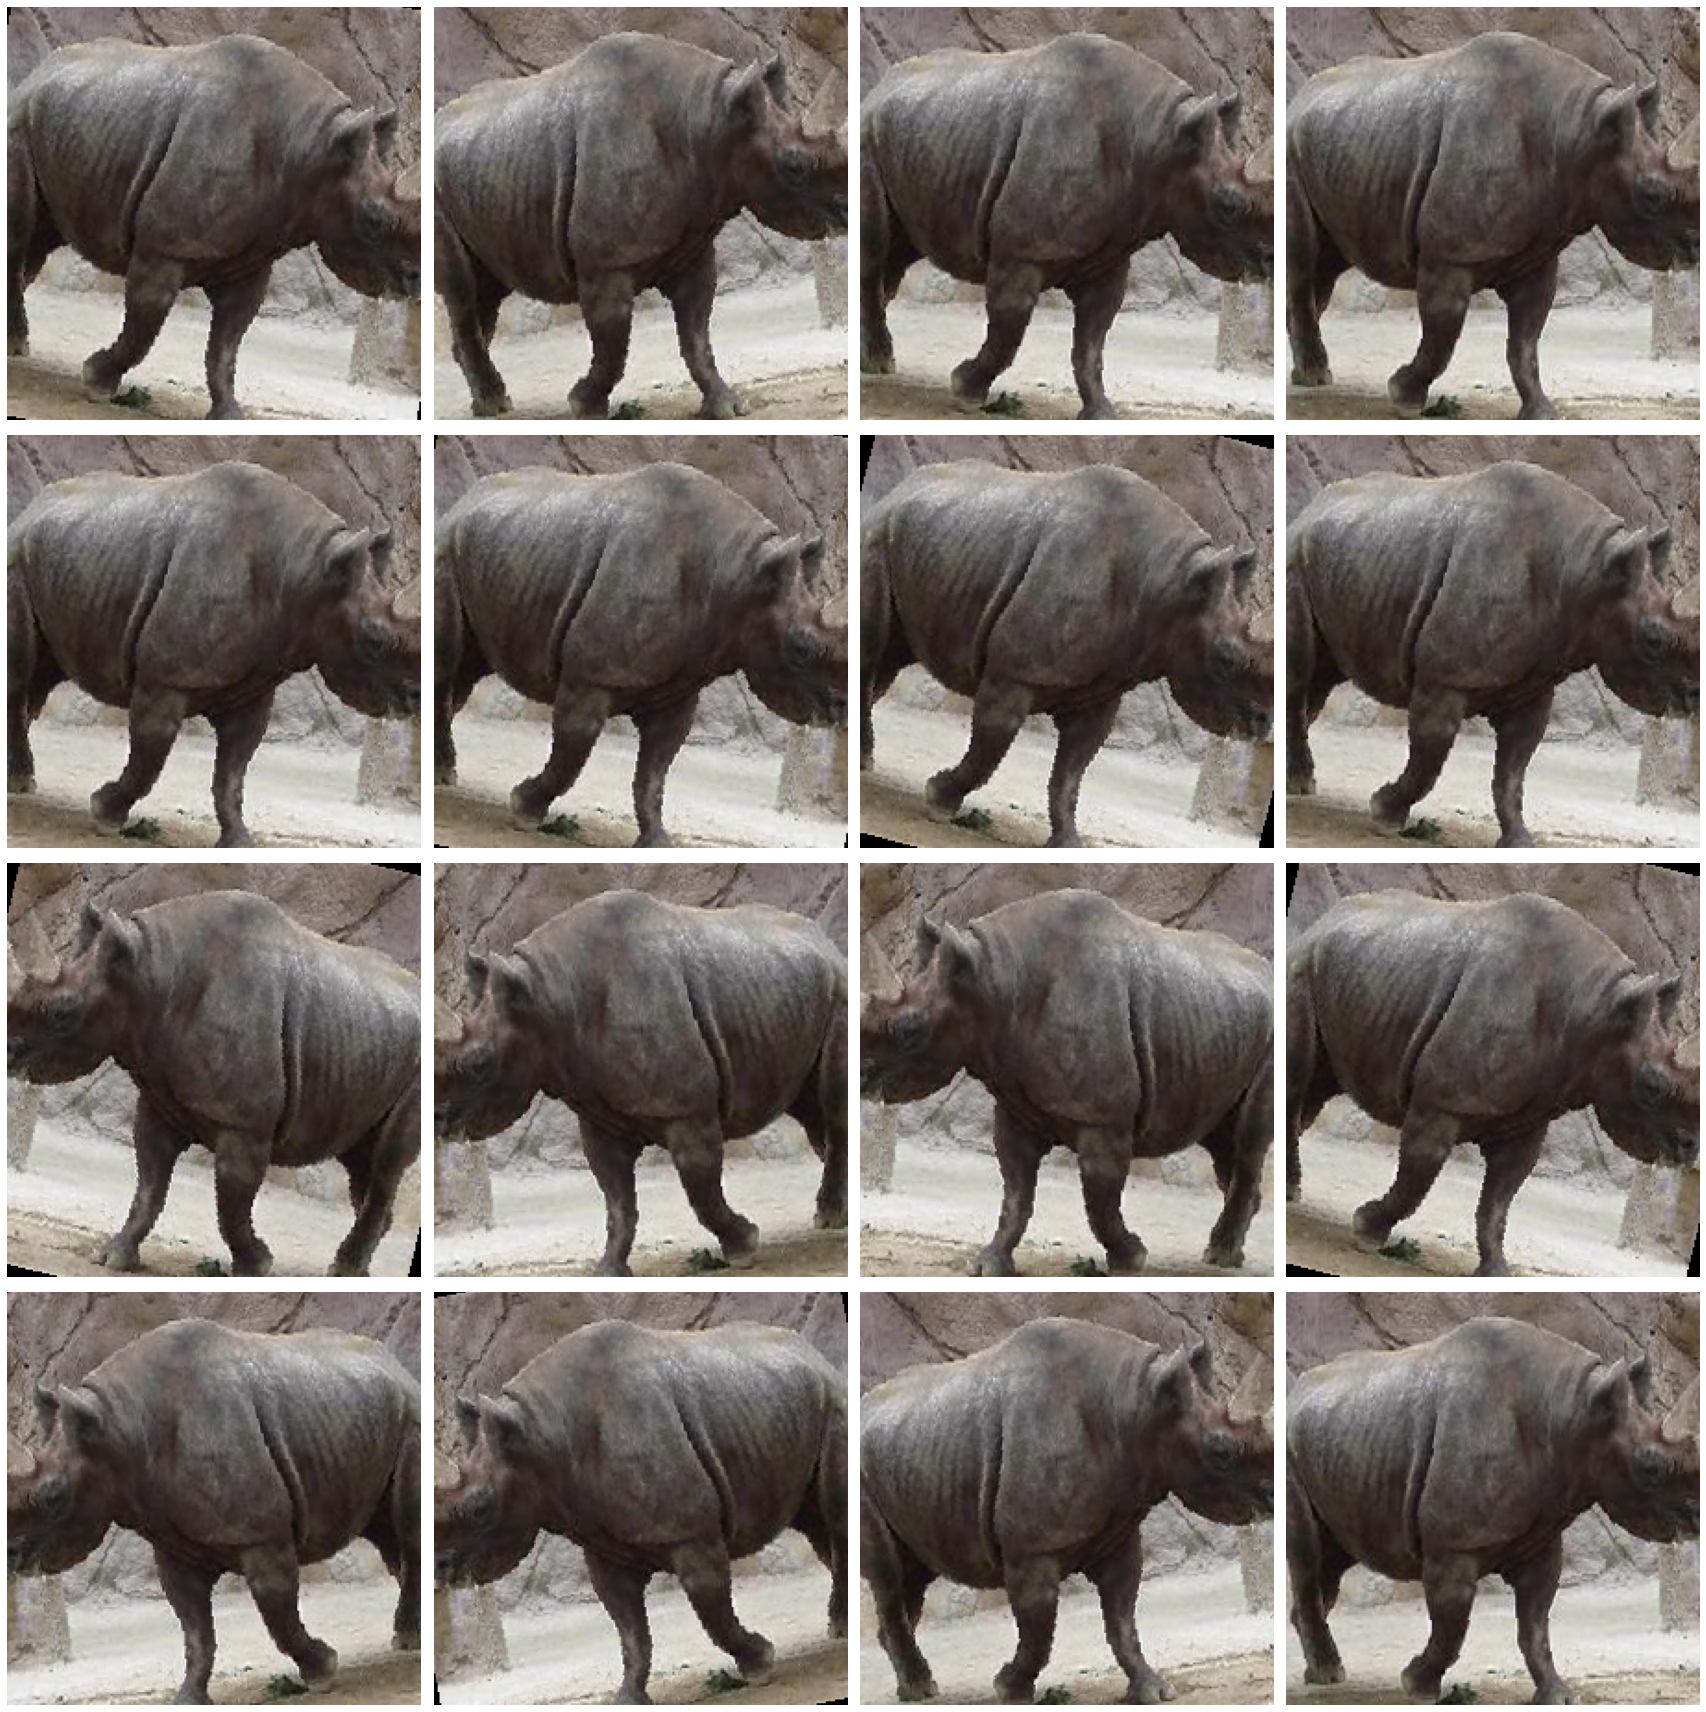

In [20]:
ex_img = Image.open('./caltech-101/train/rhino/image_0047.jpg')
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

## Data Iterators

To avoid loading all of the data into memory at once, we use training `DataLoaders`. First, we create a dataset object from the image folders, and then we pass these to a `DataLoader`. At training time, the `DataLoader` will load the images from disk, apply the transformations, and yield a batch. To train and validation, we'll iterate through all the batches in the respective `DataLoader`. 

One crucial aspect is to `shuffle` the data before passing it to the network. This means that the ordering of the image categories changes on each pass through the data (one pass through the data is one training epoch). 

In [21]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=valid_dir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [22]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

The shape of a batch is `(batch_size, color_channels, height, width)`. 

We can iterate through the `DataLoaders` when doing training, validation, and testing. This construction avoids the need to load all the data into memory and also will automatically apply the transformations to each batch. On each epoch, the `Random` transformations will be different so the network will essentially see multiple versions of each training image. 

# Pre-Trained Models for Image Classification

PyTorch has many pretrained models we can use. All of these models have been trained on Imagenet which consists of millions of images across 1000 categories. What we want to do with pretrained models is freeze the early layers, and replace the classification module with our own. 

## Approach

The approach for using a pre-trained image recognition model is well-established:

1. Load in pre-trained weights from a network trained on a large dataset
2. Freeze all the weights in the lower (convolutional) layers
    * Layers to freeze can be adjusted depending on similarity of task to large training dataset
3. Replace the classifier (fully connected) part of the network with a custom classifier
    * Number of outputs must be set equal to the number of classes
4. Train only the custom classifier (fully connected) layers for the task
    * Optimizer model classifier for smaller dataset
    
The idea behind pre-training is the early convolutional layers of a cnn extract features that are relevant for many image recognition tasks. The later, fully-connected layers, specialize to the specific dataset by learning higher-level features. Therefore, we can use the already trained convolutional layers while training only the fully-connected layers on our own dataset. Pre-trained networks have proven to be reasonably successful for a variety of tasks, and result in a significant reduction in training time and usually increases in performance. 

We'll be using the `vgg16` although the code also has support for the `resnet50`. You can modify the code to use a different network quite easily. The VGG networks had very good performance without taking a long time to train. 

## Process to Use Pre-Trained Model

We'll illustrate the process by using one model, vgg16.

First off, load in the model with pretrained weights. 

In [24]:
model = models.vgg16(pretrained=True)
model

/home/anagh/miniconda3/envs/passive_lidar/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/anagh/miniconda3/envs/passive_lidar/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The `classifier` is the part of the model that we'll train. However, for the vgg, we'll only need to train the last few layers in the classifier and not even all of the fully connected layers. 

### Freeze Early layers

We freeze all of the existing layers in the network by setting `requires_grad` to `False`. 

In [25]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

### Add on Custom Classifier

We'll train a classifier consisting of the following layers

* Fully connected with ReLU activation (n_inputs, 256)
* Dropout with 40% chance of dropping
* Fully connected with output (256, n_classes)

To build our custom classifier, we use the `nn.Sequential()` module which allows us to specify each layer one after the other. We assign our custom classifier to the final `classifier` layer in the already trained vgg network. When we add on the extra layers, they are set to `require_grad=True` by default. These will be the only layers that are trained. 

In [27]:
n_inputs = model.classifier[6].in_features
n_classes = 9

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=9, bias=True)
  )
)

The final output will be logits which we can then use in the Cross Entropy Loss. 

In [30]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,311,689 total parameters.
1,051,145 training parameters.


Even with only a few layers set to trainable, there are still over a million parameters (weights) that will be updated during training. In effect, we are _fine-tuning_ the model to work on our problem. We already know it works well on Imagenet, and because our images are relatively similar, we should expect the model to easily _transfer_ its knowledge from Imagenet to our dataset.

### Move to GPU 

To use a gpu in PyTorch, we simply move the whole model onto the gpu. Later we'll have to move the data to gpus in our training loop.

If you are using multiple gpus, you can also distribute the model across all of them with `nn.DataParallel`. 

In [31]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

## Function to Load in Pretrained Model

We can refactor all that code into a single function that returns a pretrained model. This only accepts the vgg16 or resnet50 at the moment but can be extended to use other models. 

In [59]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model

This should return the same as the pretrained model with the custom classifier. In the case of resnet, we replace the `fc` layers with the same classifier.

The `torchsummary` library has a helpful function called `summary` which summarizes our model.

In [60]:
model = get_pretrained_model('vgg16')
if multi_gpu:
    summary(
        model.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 256, 56, 56]         590,080
             ReLU-14         [128, 256,

We can see that the model is quite large and training all of the layers would take a considerable time. Even with only a few layers to train, this can still take a while to train. You might need to decrease the `batch_size` if this is not fitting on your gpu (hopefully you have one).

#### Mapping of Classes to Indexes

To keep track of the predictions made by the model, we create a mapping of classes to indexes and indexes to classes. This will let us know the actual class for a given prediction.

In [61]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_ for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'Leopards'),
 (1, 'airplanes'),
 (2, 'butterfly'),
 (3, 'camera'),
 (4, 'elephant'),
 (5, 'lamp'),
 (6, 'rhino'),
 (7, 'umbrella'),
 (8, 'watch')]

# Training Loss and Optimizer

The loss is the cross entropy loss and the optimizer is the Adam optimizer. The cross entropy loss in PyTorch expects logits. The optimizer is told to optimize the model parameters (only a few of which require a gradient). 

* Loss (criterion): keeps track of the loss itself and the gradients of the loss with respect to the model parameters (weights)
* Optimizer: updates the parameters (weights) with the gradients 

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Below we can look at the parameters (weights) that will be updated by the optimizer during training.

In [63]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([9, 256])
torch.Size([9])


# Training

For training, we iterate through the train `DataLoader`, each time passing one batch through the model. One complete pass through the training data is known as an `epoch`, and we train for a set number of epochs or until early stopping kicks in (more below). After each batch, we calculate the loss (with `criterion(output, targets)`) and then calculate the gradients of the loss with respect to the model parameters with `loss.backward()`. This uses autodifferentiation and backpropagation to calculate the gradients. 

After calculating the gradients, we call `optimizer.step()` to update the model parameters with the gradients. This is done on every training batch so we are implementing stochastic gradient descent (or rather a version of it with momentum known as Adam). For each batch, we also compute the accuracy for monitoring and after the training loop has completed, we start the validation loop. This will be used to carry out early stopping.


## Early Stopping

Early stopping halts the training when the validation loss has not decreased for a number of epochs. Each time the validation loss does decrease, the model weights are saved so we can later load in the best model. Early stopping is an effective method to prevent overfitting on the training data. If we continue training, the training loss will continue to decrease, but the validation loss will increase because the model is starting to memorize the training data. Early stopping prevents this from happening, and, if we save the model each epoch when the validation loss decreases, we are able to retrieve the model that does best on the validation data.

Early stopping is implemented by iterating through the validation data at the end of each training epoch and calculating the loss. We use the complete validation data every time and record whether or not the loss has decreased. If it has not for a number of epochs, we stop training, retrieve the best weights, and return them. When in the validation loop, we make sure not to update the model parameters. 

### Training Function

The below function trains the network while monitoring a number of different parameters. We train with early stopping on the validation set. There are a number of parameters that I've tried to explain in the doc string. Hopefully, the comments and background make things somewhat understandable! 

In [64]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are logits
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max logits
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [65]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 5.86 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.1038 	Validation Loss: 0.0474
		Training Accuracy: 96.76%	 Validation Accuracy: 98.56%
Epoch: 3	100.00% complete. 5.73 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.0585 	Validation Loss: 0.0468
		Training Accuracy: 97.97%	 Validation Accuracy: 97.60%
Epoch: 5	100.00% complete. 5.82 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.0272 	Validation Loss: 0.0350
		Training Accuracy: 99.35%	 Validation Accuracy: 97.60%
Epoch: 7	100.00% complete. 5.77 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.0155 	Validation Loss: 0.0309
		Training Accuracy: 99.59%	 Validation Accuracy: 99.04%
Epoch: 9	100.00% complete. 5.75 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.0156 	Validation Loss: 0.0349
		Training Accuracy: 99.43%	 Validation Accuracy: 99.04%
Epoch: 11	100.00% complete. 5.74 seconds elapsed in epoch.
Epoch: 11 	Training Loss: 0.0217 	Validation Los

# Training Results

We can inspect the training progress by looking at the `history`. 

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

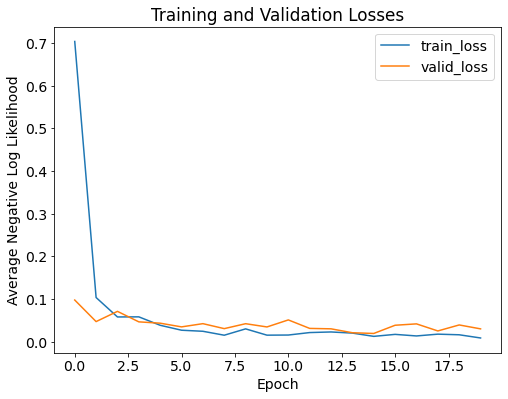

In [67]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

As expected, the training loss decreases continually with epochs. At a certain point however, the validation loss stops decreasing. There is not a massive amount of overfitting, likely because we were using Dropout. With the divergence in losses, there is likely not much more to gain from further training.

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

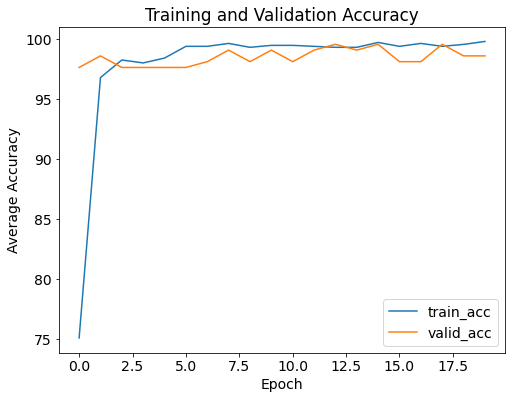

In [68]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

As with the losses, the training accuracy increases (nearly to perfect) while the validation accuracy plateaus. The model is able to achieve above 80% accuracy right away, an indication that the convolution weights learned on Imagenet were able to easily transfer to our dataset.

# Saving Model

The `train` function saves the best model `state_dict()` which are the weights of the model. To save more information about the model, we use the below function. 

In [69]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [70]:
save_checkpoint(model, path=checkpoint_path)

## Load in a Checkpoint

Now we need to write the function to load in the checkpoint. This just takes in a `path` and returns a model from a saved checkpoint.

In [71]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [72]:
model, optimizer = load_checkpoint(path=checkpoint_path)

if multi_gpu:
    summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)
else:
    summary(model, input_size=(3, 224, 224), batch_size=batch_size)

135,311,689 total parameters.
1,051,145 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 2

We can now use these two functions to save and load in a complete model. We can use this model to continue training. 

In [73]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Model has been trained for: 20 epochs.

Epoch: 1	100.00% complete. 5.79 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.0095 	Validation Loss: 0.0437
		Training Accuracy: 99.68%	 Validation Accuracy: 98.56%
Epoch: 3	100.00% complete. 5.75 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.0112 	Validation Loss: 0.0465
		Training Accuracy: 99.59%	 Validation Accuracy: 98.56%
Epoch: 5	100.00% complete. 5.76 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.0144 	Validation Loss: 0.0309
		Training Accuracy: 99.43%	 Validation Accuracy: 98.56%
Epoch: 7	100.00% complete. 5.78 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.0072 	Validation Loss: 0.0403
		Training Accuracy: 99.84%	 Validation Accuracy: 98.56%

Early Stopping! Total epochs: 7. Best epoch: 2 with loss: 0.02 and acc: 98.56%
54.53 total seconds elapsed. 6.82 seconds per epoch.


Adapted from [Samuel James](https://dev.to/abiodunjames/building-an-image-classifier-using-pytorch-46dk)